## Data preprocessing

### Load libraries

In [723]:
# Librerie base
import numpy as np
import pandas as pd

# Visualizzazione
import matplotlib.pyplot as plt  
import seaborn as sns

# Modelli statistici
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

# Libreria ISLP (Statistical Learning)
from ISLP import load_data
from ISLP.models import (ModelSpec as MS ,summarize, poly)

We will use the Aircraft Price dataset, from Kaggle. 

### Dataset load 

In [724]:
# carico il dataset e stampo l'head
data = pd.read_csv("Data/aircraft_price.csv", encoding='utf-8')
target = 'price'

### data info

In [725]:
data.columns

Index(['model_name', 'engine_type', 'engine_power', 'max_speed',
       'cruise_speed', 'stall_speed', 'fuel_tank', 'all_eng_roc',
       'out_eng_roc', 'takeoff_distance', 'landing_distance', 'empty_weight',
       'length', 'wing_span', 'range', 'price'],
      dtype='object')

In [726]:
print(data.describe())

       engine_power   max_speed  cruise_speed  stall_speed     fuel_tank  \
count    517.000000  517.000000    517.000000   517.000000    517.000000   
mean     869.328820  212.794971    200.177950    60.656673   1419.379110   
std     1783.602771  114.106830    103.358089    16.432874   4278.320773   
min       60.000000   64.000000     70.000000    27.000000     12.000000   
25%      200.000000  143.000000    131.000000    50.000000     50.000000   
50%      285.000000  177.000000    169.000000    56.000000     89.000000   
75%      550.000000  238.000000    229.000000    73.000000    335.000000   
max    14750.000000  755.000000    511.000000   115.000000  41000.000000   

        all_eng_roc  out_eng_roc  takeoff_distance  landing_distance  \
count    517.000000   517.000000        517.000000        517.000000   
mean    1717.558994  2047.065764       1732.750484       7485.489362   
std     1453.489518  1123.433947        713.646967      10289.442474   
min      360.000000   457.0

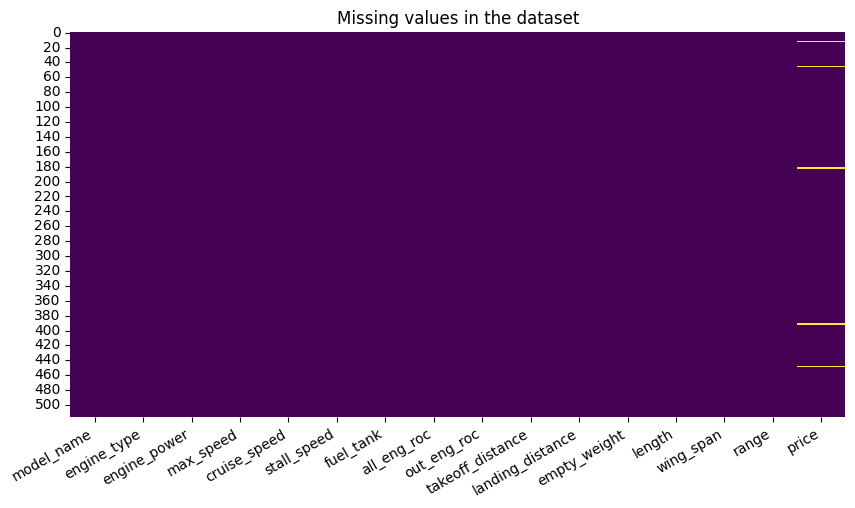

In [727]:
# Plot per mostrare record null
plt.figure(figsize=(10, 5))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing values in the dataset')
plt.xticks(rotation=30, ha='right')  # Ruota le etichette di 45 gradi e le allinea a destra
plt.show()

In [728]:
# Controllo i dati nulli
columnsWithNulls=data.isnull().sum().sort_values(ascending=False)
columnsWithNulls=columnsWithNulls[columnsWithNulls>0]
print(columnsWithNulls)

price    10
dtype: int64


In [729]:
# Controllo in percentuale quanti dati mancano così da capire come trattarli, pongo una soglia di eliminazione del regressore nel caso di +30% di dati mancanti
missing_pct = data.isnull().mean() * 100
missing_only = missing_pct[missing_pct > 0].sort_values(ascending=False)
print(missing_only )

price    1.934236
dtype: float64


In [730]:
#Drop dati nulli
data.dropna(axis=0, inplace=True)
missing_pct = data.isnull().sum()
print("Number of null data: \n")
print(missing_pct)

Number of null data: 

model_name          0
engine_type         0
engine_power        0
max_speed           0
cruise_speed        0
stall_speed         0
fuel_tank           0
all_eng_roc         0
out_eng_roc         0
takeoff_distance    0
landing_distance    0
empty_weight        0
length              0
wing_span           0
range               0
price               0
dtype: int64


In [731]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
numeric_data = data.select_dtypes(include=[np.number])
# Handle missing or infinite values in the data
numeric_data_cleaned = numeric_data.replace([np.inf, -np.inf], np.nan).dropna()

numeric_data_with_const = sm.add_constant(numeric_data_cleaned)

# Calcola il VIF per ciascuna variabile
vif_data = pd.DataFrame()
vif_data["Regressor"] = numeric_data_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data_with_const.values, i) for i in range(numeric_data_with_const.shape[1])]

vif_data = vif_data.sort_values("VIF", ascending=False)
print(vif_data)


           Regressor         VIF
9   landing_distance  172.362316
10      empty_weight  133.363446
0              const   94.261829
5          fuel_tank   27.041258
1       engine_power   24.515553
11            length   20.306492
3       cruise_speed   10.601181
14             price    8.626325
12         wing_span    7.253156
7        out_eng_roc    6.518800
2          max_speed    5.301080
8   takeoff_distance    5.244060
13             range    4.653472
4        stall_speed    4.548751
6        all_eng_roc    2.715075


### Skewness check

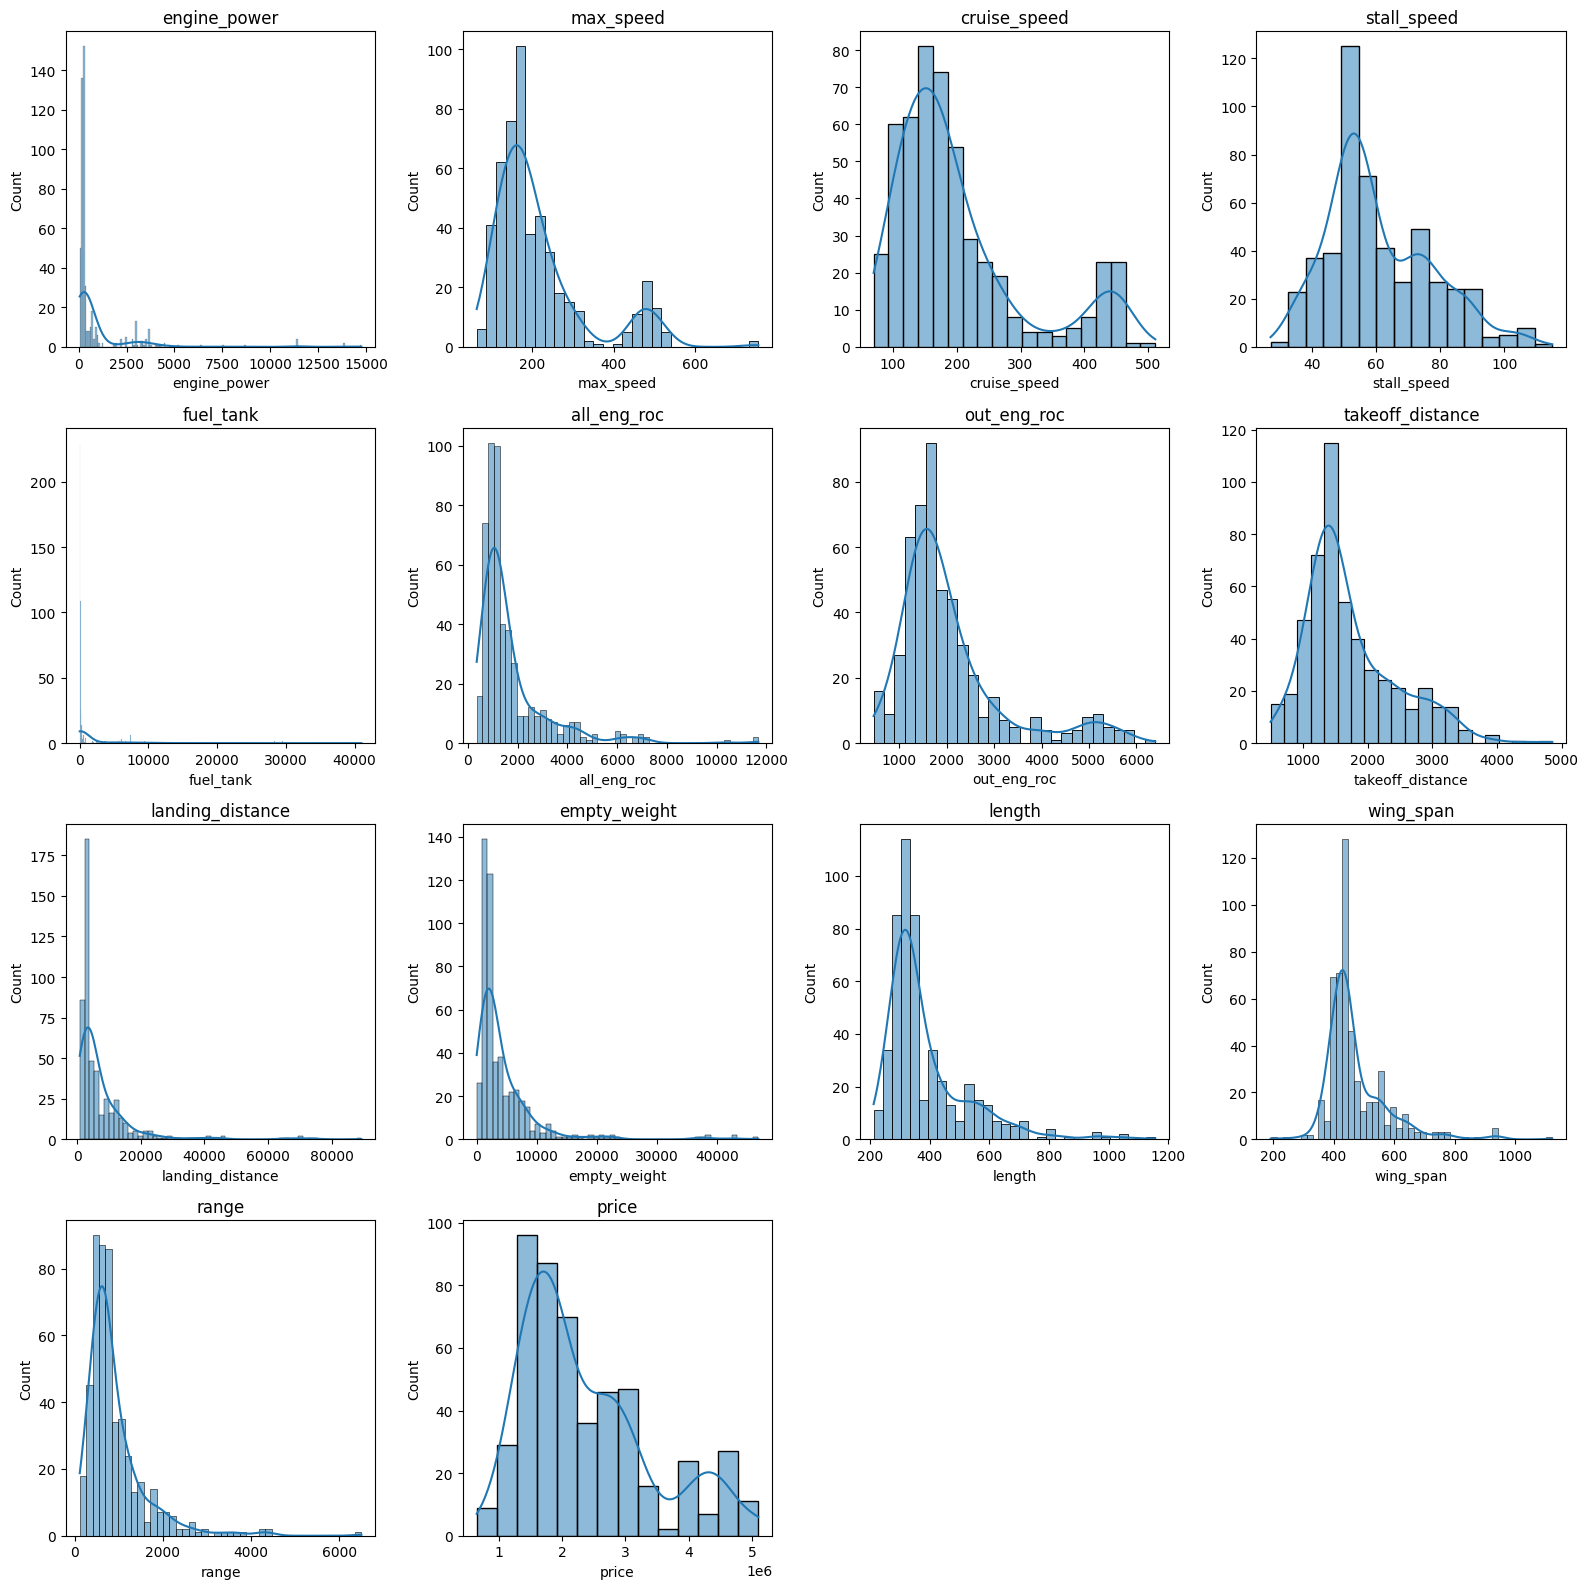

In [732]:
# Plot distributions of all numeric variables
numeric_cols = data.select_dtypes(include=['number']).columns
n = len(numeric_cols)
cols = 4
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
for ax, col in zip(axes.flatten(), numeric_cols):
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(col)

# remove any unused subplots
for ax in axes.flatten()[n:]:
    ax.remove()

plt.tight_layout()
plt.show()

In [733]:
#calcooliamo la skewness
skewness = data[numeric_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
print("Skewness of numeric variables:")
print(skewness)


Skewness of numeric variables:
fuel_tank           5.046265
engine_power        4.690213
landing_distance    4.296546
empty_weight        4.191493
all_eng_roc         3.003339
range               2.945743
wing_span           2.199430
length              2.101332
out_eng_roc         1.746618
max_speed           1.691196
cruise_speed        1.379109
takeoff_distance    1.054754
price               0.949636
stall_speed         0.709297
dtype: float64


In [734]:
# colonne da log-trasformare (skewness > 1)
skewed_feats = [
    'fuel_tank', 'engine_power', 'landing_distance', 'empty_weight',
    'all_eng_roc', 'range', 'wing_span', 'length',
    'out_eng_roc', 'max_speed', 'cruise_speed', 'takeoff_distance'
]

# copia del dataset e applicazione del log(1+x)
logData = data.copy()
for col in skewed_feats:
    logData[col] = np.log1p(logData[col])

# log-trasformartion anche del target:
logData['price'] = np.log1p(logData['price'])

# logData è ora il tuo dataset con le variabili selezionate log-trasformate


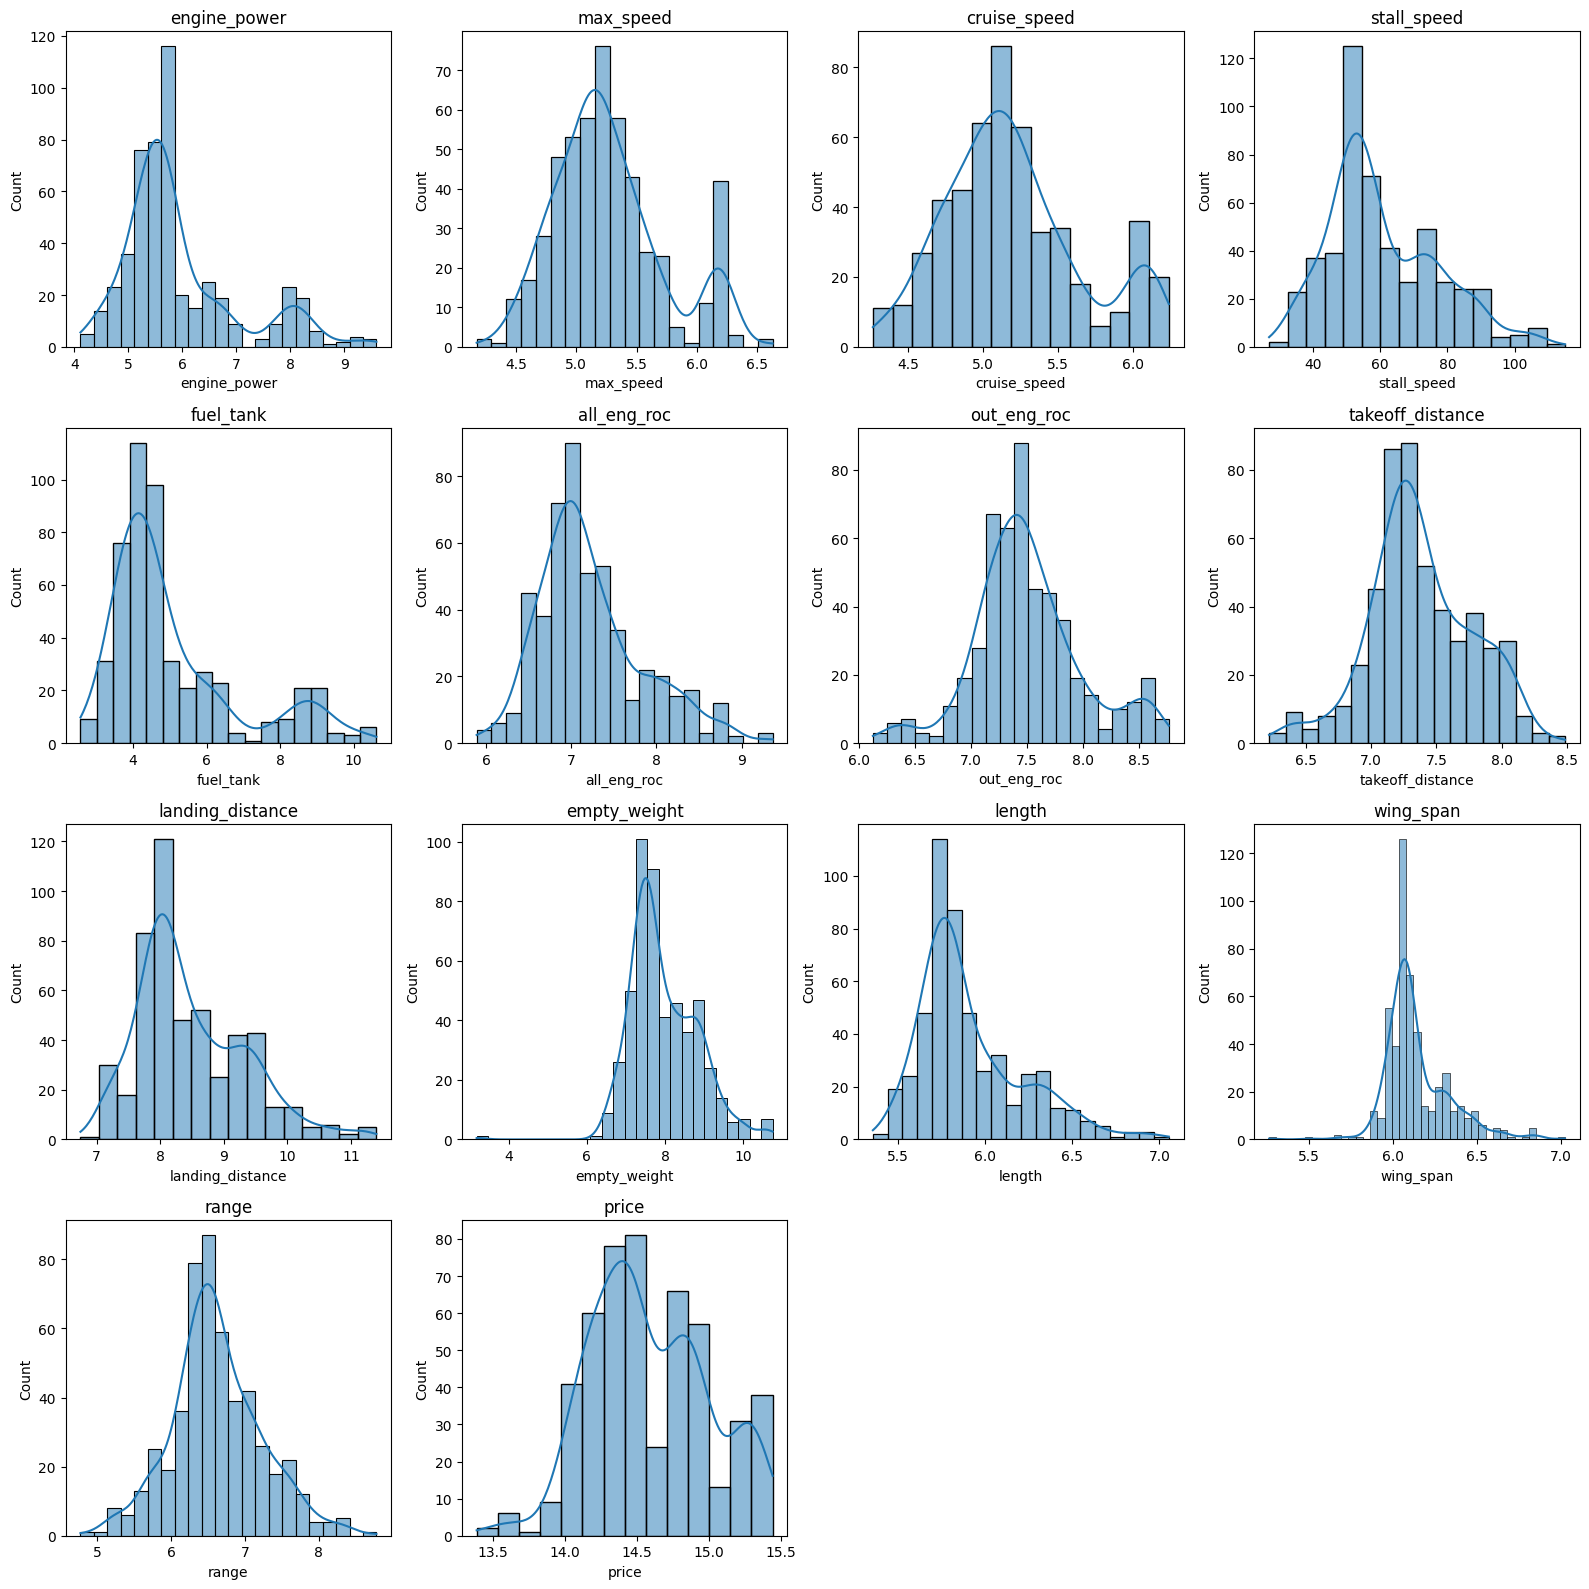

In [735]:
#verifichiamo la skewness
# Plot distributions of all numeric variables
numeric_cols = logData.select_dtypes(include=['number']).columns
n = len(numeric_cols)
cols = 4
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
for ax, col in zip(axes.flatten(), numeric_cols):
    sns.histplot(logData[col], kde=True, ax=ax)
    ax.set_title(col)

# remove any unused subplots
for ax in axes.flatten()[n:]:
    ax.remove()

plt.tight_layout()
plt.show()

## log transformation of target 

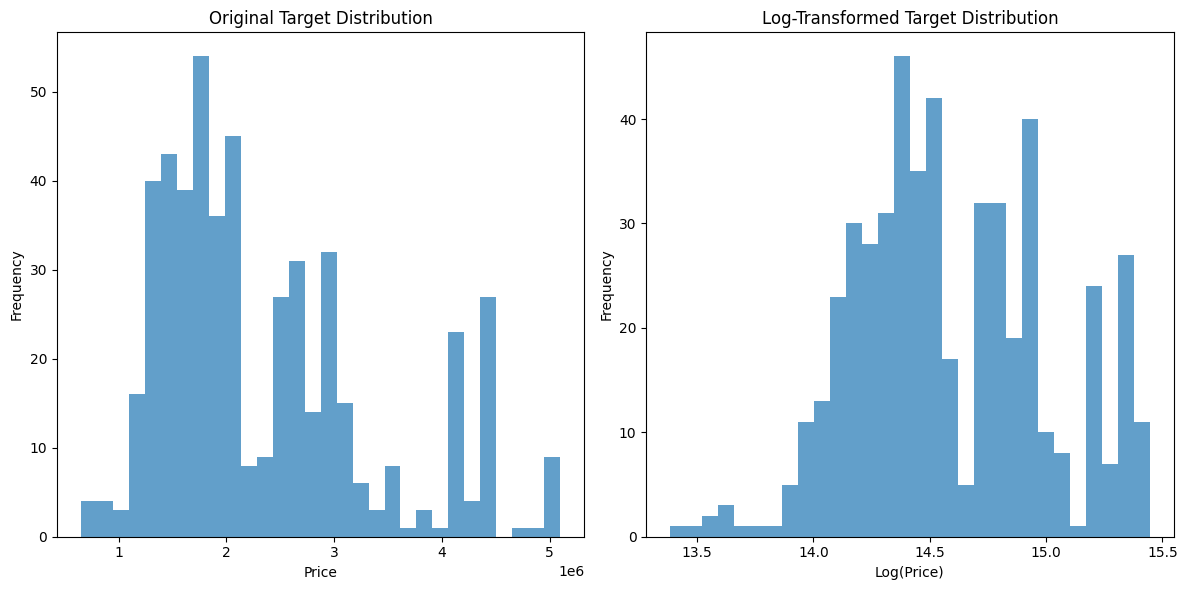

In [736]:
# Log-transform the target variable and compare it with the original target distribution
target = 'price'
log_target = np.log(data[target])

# Plot the original and log-transformed target distributions
plt.figure(figsize=(12, 6))

# Original target distribution
plt.subplot(1, 2, 1)
plt.hist(data[target], bins=30, alpha=0.7)
plt.title('Original Target Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Log-transformed target distribution
plt.subplot(1, 2, 2)
plt.hist(log_target, bins=30, alpha=0.7)
plt.title('Log-Transformed Target Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


#
- **Distribuzione originale** (istogramma blu): il prezzo è fortemente asimmetrico a destra, con code lunghe fino a 5 M€ e una concentrazione massima attorno a 1–3 M€. Questo livello di skewness può causare problemi di eteroschedasticità e di instabilità nella regressione OLS.  
- **Distribuzione log** (istogramma verde): dopo aver fatto `log(price)`, i valori si raggruppano su una curva molto più simile a una normale — la coda lunga si riduce, e l’intervallo diventa circa 13.5–15.5 sul logaritmo naturale.  

**Cosa ci dice?**  
1. **Assunti di OLS**: il log‐transform aiuta a soddisfare meglio l’ipotesi di normalità dei residui e di varianza costante.  
2. **Linearità percentuale**: un modello lineare su \(\log(price)\) interpreta i coefficienti come variazioni percentuali del prezzo, spesso più sensate di variazioni assolute su una scala ampia.  
3. **Robustezza**: riduci l’influenza degli outlier più estremi, migliorando stabilità e predittività.  


## Correlation matrix

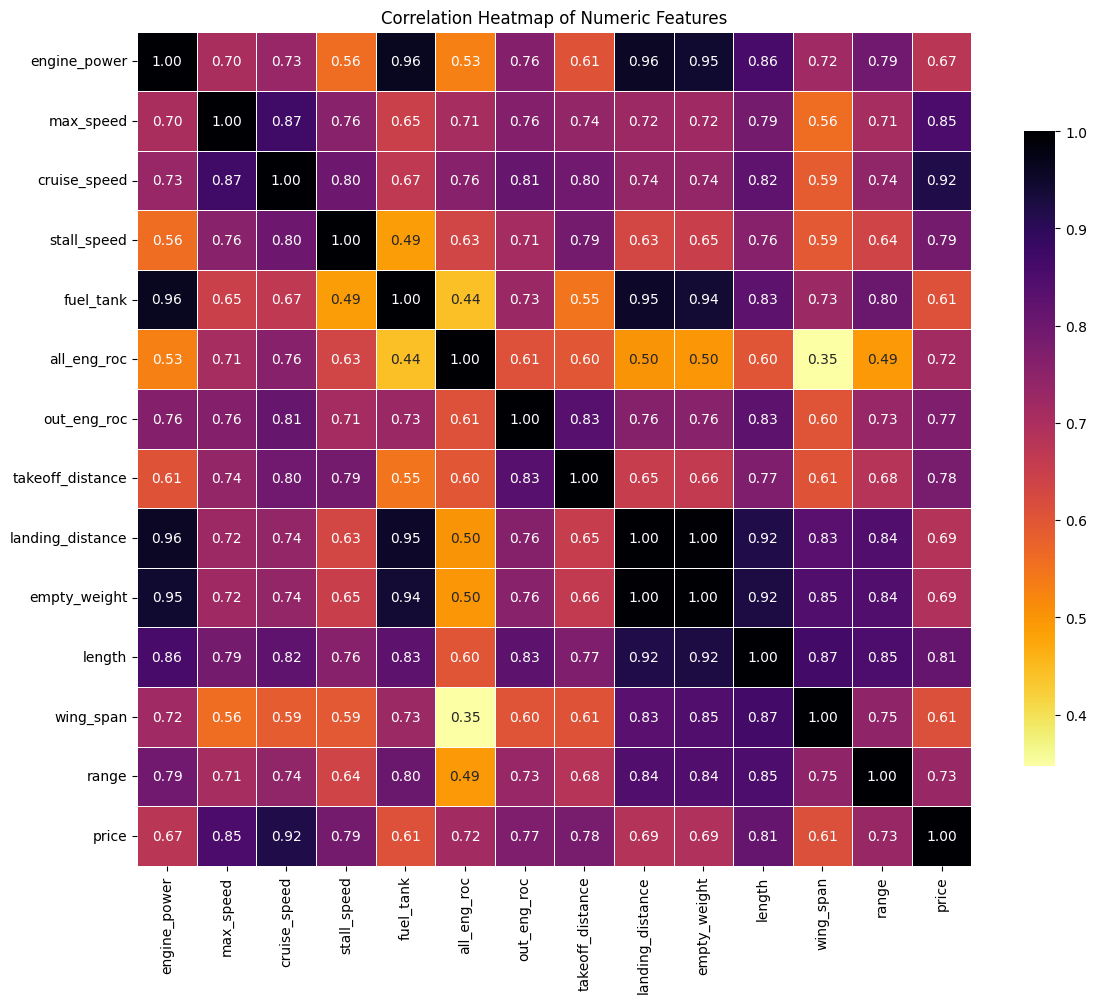

In [737]:
# Seleziona le colonne numeriche
numeric_data = data.select_dtypes(include=[np.number])
if numeric_data.shape[1] >= 4:
    # Calcola la matrice di correlazione
    corr = numeric_data.corr()
    
    # Imposta la figura
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr,
        annot=True,
        fmt='.2f',
        cmap='inferno_r',
        square=True,
        linewidths=.5,
        cbar_kws={"shrink": .75}
    )
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a meaningful correlation heatmap')

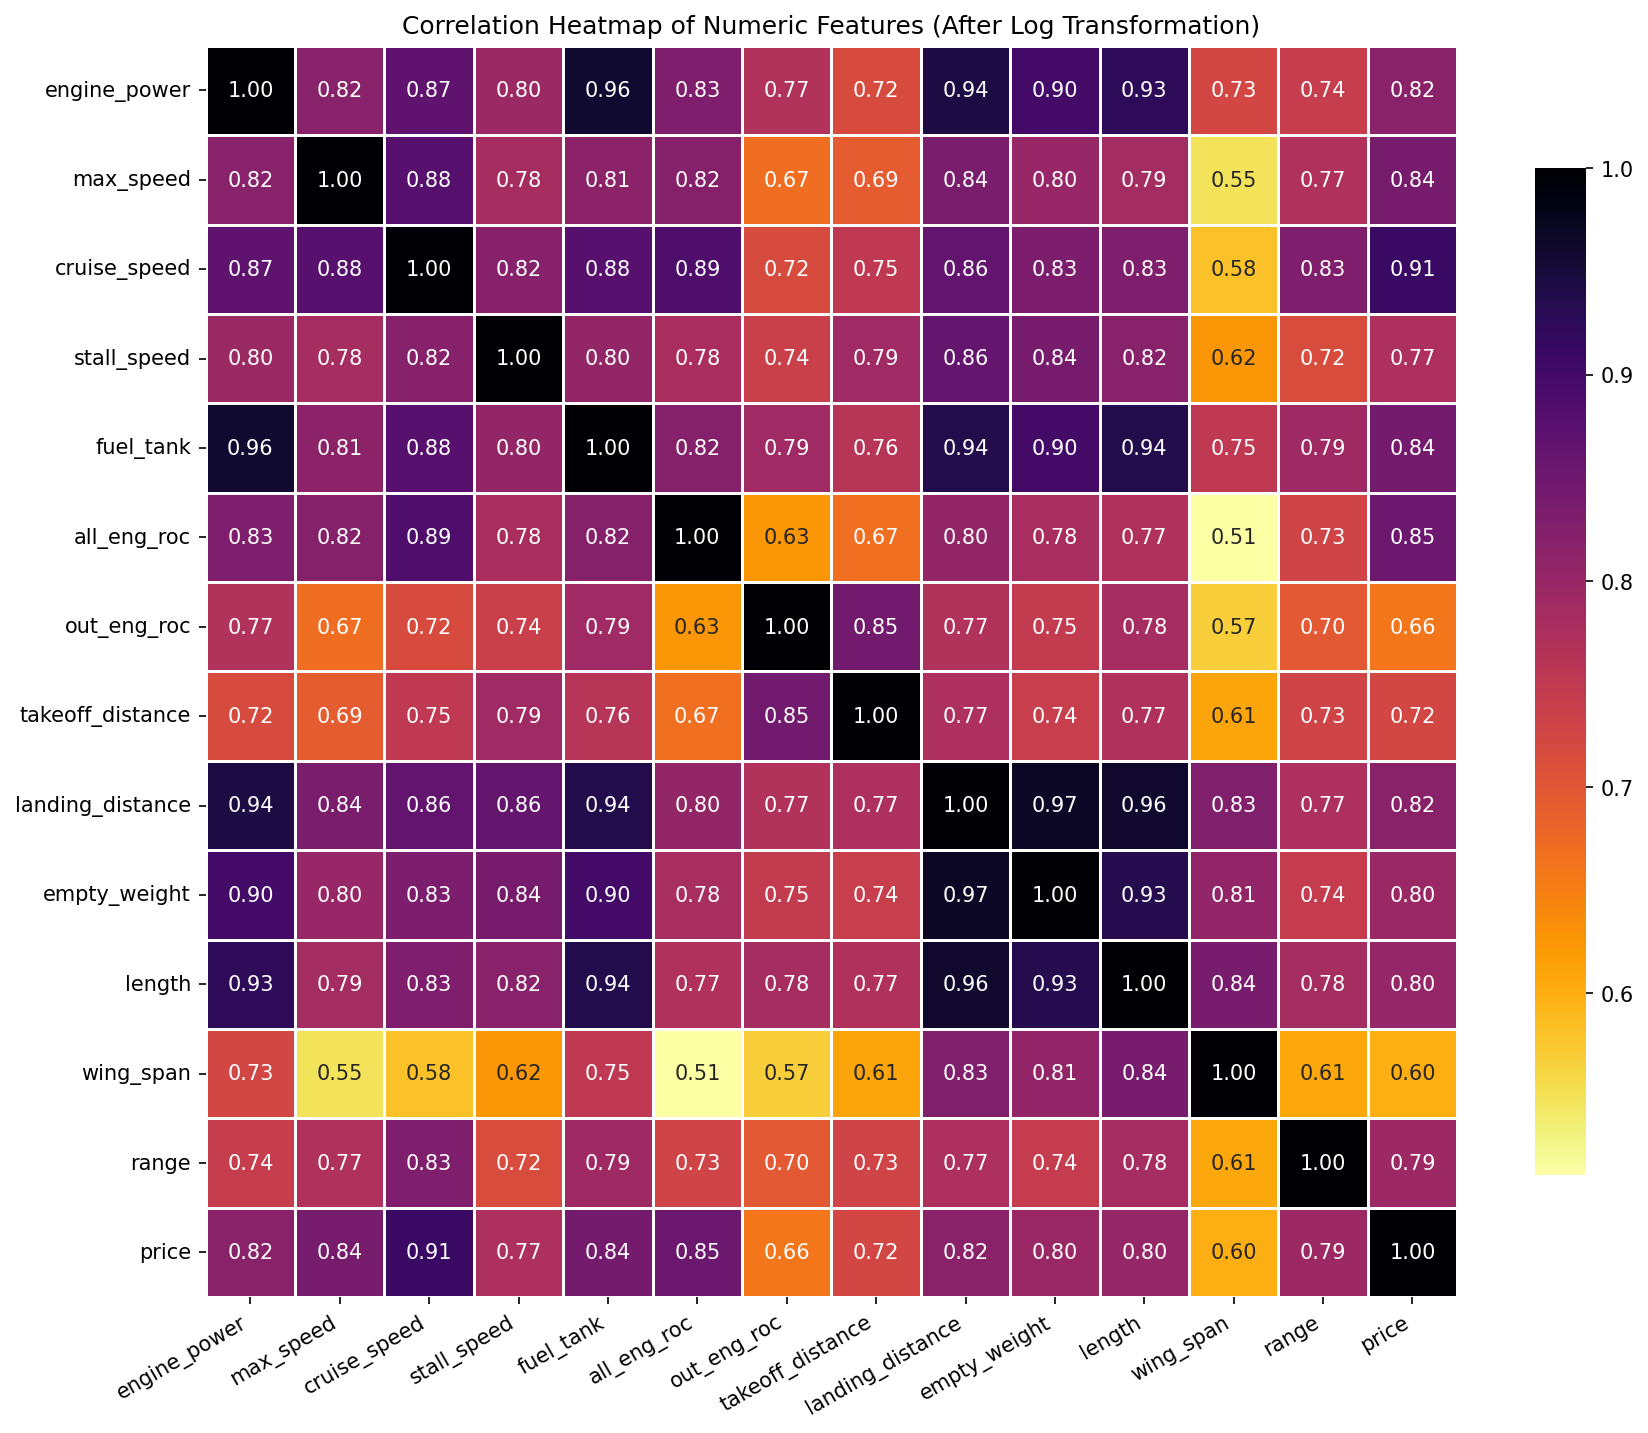

In [738]:
# Seleziona le colonne numeriche
numeric_data = logData.select_dtypes(include=[np.number])
if numeric_data.shape[1] >= 4:
    # Calcola la matrice di correlazione
    corr = numeric_data.corr()
    
    # Imposta la figura con una risoluzione migliore
    plt.figure(figsize=(12, 10), dpi=150)
    sns.heatmap(
        corr,
        annot=True,
        fmt='.2f',
        cmap='inferno_r',
        square=True,
        linewidths=.5,
        cbar_kws={"shrink": .75}
    )
    plt.title('Correlation Heatmap of Numeric Features (After Log Transformation)')
    plt.xticks(rotation=30, ha='right')  # Inclina i nomi dell'asse x di 30 gradi
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a meaningful correlation heatmap')

## VIF 

### without log transformation

In [739]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Seleziona le colonne numeriche
numeric_data = data.select_dtypes(include=[np.number])
# Handle missing or infinite values in the data
numeric_data_cleaned = numeric_data.replace([np.inf, -np.inf], np.nan).dropna()
numeric_data_with_const = sm.add_constant(numeric_data_cleaned)
# Calcola il VIF per ciascuna variabile
vif_data = pd.DataFrame()
vif_data["Regressor"] = numeric_data_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data_with_const.values, i) for i in range(numeric_data_with_const.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)
print(vif_data)

           Regressor         VIF
9   landing_distance  172.362316
10      empty_weight  133.363446
0              const   94.261829
5          fuel_tank   27.041258
1       engine_power   24.515553
11            length   20.306492
3       cruise_speed   10.601181
14             price    8.626325
12         wing_span    7.253156
7        out_eng_roc    6.518800
2          max_speed    5.301080
8   takeoff_distance    5.244060
13             range    4.653472
4        stall_speed    4.548751
6        all_eng_roc    2.715075


### with log transformation

In [740]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Seleziona le colonne numeriche
numeric_data = logData.select_dtypes(include=[np.number])
# Handle missing or infinite values in the data
numeric_data_cleaned = numeric_data.replace([np.inf, -np.inf], np.nan).dropna()
numeric_data_with_const = sm.add_constant(numeric_data_cleaned)
# Calcola il VIF per ciascuna variabile
vif_data = pd.DataFrame()
vif_data["Regressor"] = numeric_data_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data_with_const.values, i) for i in range(numeric_data_with_const.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)
print(vif_data)

           Regressor          VIF
0              const  9776.033312
9   landing_distance    54.834620
1       engine_power    21.697669
11            length    19.276523
5          fuel_tank    18.831683
10      empty_weight    17.199763
3       cruise_speed    12.825950
14             price     7.404855
12         wing_span     6.337481
6        all_eng_roc     6.044152
2          max_speed     5.758867
4        stall_speed     5.532121
8   takeoff_distance     5.359086
7        out_eng_roc     5.234937
13             range     4.146934


**Commento sui VIF**  
Dall’analisi dei VIF emerge innanzitutto che alcune coppie di variabili sono fortemente collineari (in particolare **landing_distance** ed **empty_weight**, con VIF > 50 anche dopo la log-trasformazione). Questo fenomeno può compromettere la stabilità numerica dei coefficienti OLS e rendere difficoltosa l’interpretazione individuale degli effetti.  

La log-trasformazione delle feature ha ridotto significativamente i VIF globali (ad es. landing_distance da ~172 a ~55, engine_power da ~24 a ~22, fuel_tank da ~27 a ~19), ma rimangono ancora variabili con VIF superiori a 10 (cruise_speed, length, fuel_tank, empty_weight).  

🔹 **Prossimi passi consigliati**  
1. **Rimuovere** o **combinare** le variabili con VIF estremamente alti (landing_distance vs empty_weight).  
2. Valutare la creazione di feature derivate (es. rapporto `power/weight`) per catturare l’informazione condivisa e ridurre la collinearità.  
3. Utilizzare Ridge o Lasso nel modello finale, che penalizzano automaticamente le variabili più collineari e stabilizzano la stima.  

Così avremo un modello più robusto e interpretabile, con coefficienti meno sensibili alle ridondanze tra le covariate.


## Feature engineering for VIF reduction

### ⚠️ Ora otteniamo **df** che è il nuovo dataframe uguale a logData a meno delle variabili con VIF > 10

In [741]:
VIF_THRESHOLD = 10.0

# partiamo da una copia di logData
data_pruned = logData.copy()

# consideriamo solo le colonne numeriche
numeric_data_cleaned = (
    data_pruned
    .select_dtypes(include=[np.number])
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)

variables = numeric_data_cleaned.columns.tolist()
dropped_cols = []

def calculate_vif(df):
    df_const = sm.add_constant(df)
    vif = pd.DataFrame({
        "Regressor": df_const.columns,
        "VIF": [
            variance_inflation_factor(df_const.values, i)
            for i in range(df_const.shape[1])
        ]
    })
    return vif.sort_values("VIF", ascending=False)

while True:
    vif_df = calculate_vif(numeric_data_cleaned[variables])
    vif_no_const = vif_df[vif_df.Regressor != "const"]
    max_vif = vif_no_const["VIF"].max()
    if max_vif <= VIF_THRESHOLD:
        print(f"Tutti i VIF sono sotto {VIF_THRESHOLD}")
        break
    var_to_drop = vif_no_const.iloc[0]["Regressor"]
    print(f"Rimuovo {var_to_drop} (VIF={max_vif:.1f})")
    dropped_cols.append(var_to_drop)
    variables.remove(var_to_drop)
    numeric_data_cleaned.drop(columns=[var_to_drop], inplace=True)

print("Colonne eliminate:", dropped_cols)

# otteniamo df senza toccare data/logData
df = data_pruned.drop(columns=dropped_cols)
print("Colonne finali in df:", df.columns.tolist())


Rimuovo landing_distance (VIF=54.8)
Rimuovo fuel_tank (VIF=18.8)
Rimuovo length (VIF=17.3)
Rimuovo cruise_speed (VIF=12.3)
Rimuovo empty_weight (VIF=10.1)
Tutti i VIF sono sotto 10.0
Colonne eliminate: ['landing_distance', 'fuel_tank', 'length', 'cruise_speed', 'empty_weight']
Colonne finali in df: ['model_name', 'engine_type', 'engine_power', 'max_speed', 'stall_speed', 'all_eng_roc', 'out_eng_roc', 'takeoff_distance', 'wing_span', 'range', 'price']


In [742]:
#VIF finale
vif_final = calculate_vif(numeric_data_cleaned[variables])
print(vif_final)

#numeric_data

          Regressor          VIF
0             const  6462.811877
1      engine_power     7.886843
9             price     5.741233
4       all_eng_roc     5.643680
6  takeoff_distance     5.191693
5       out_eng_roc     4.908425
2         max_speed     4.891332
3       stall_speed     4.344890
8             range     3.526301
7         wing_span     2.654361


⚠️ **df** è il nuovo dataframe uguale a logData a meno delle variabili con VIF > 10.
usiamo **df** d'ora in avanti


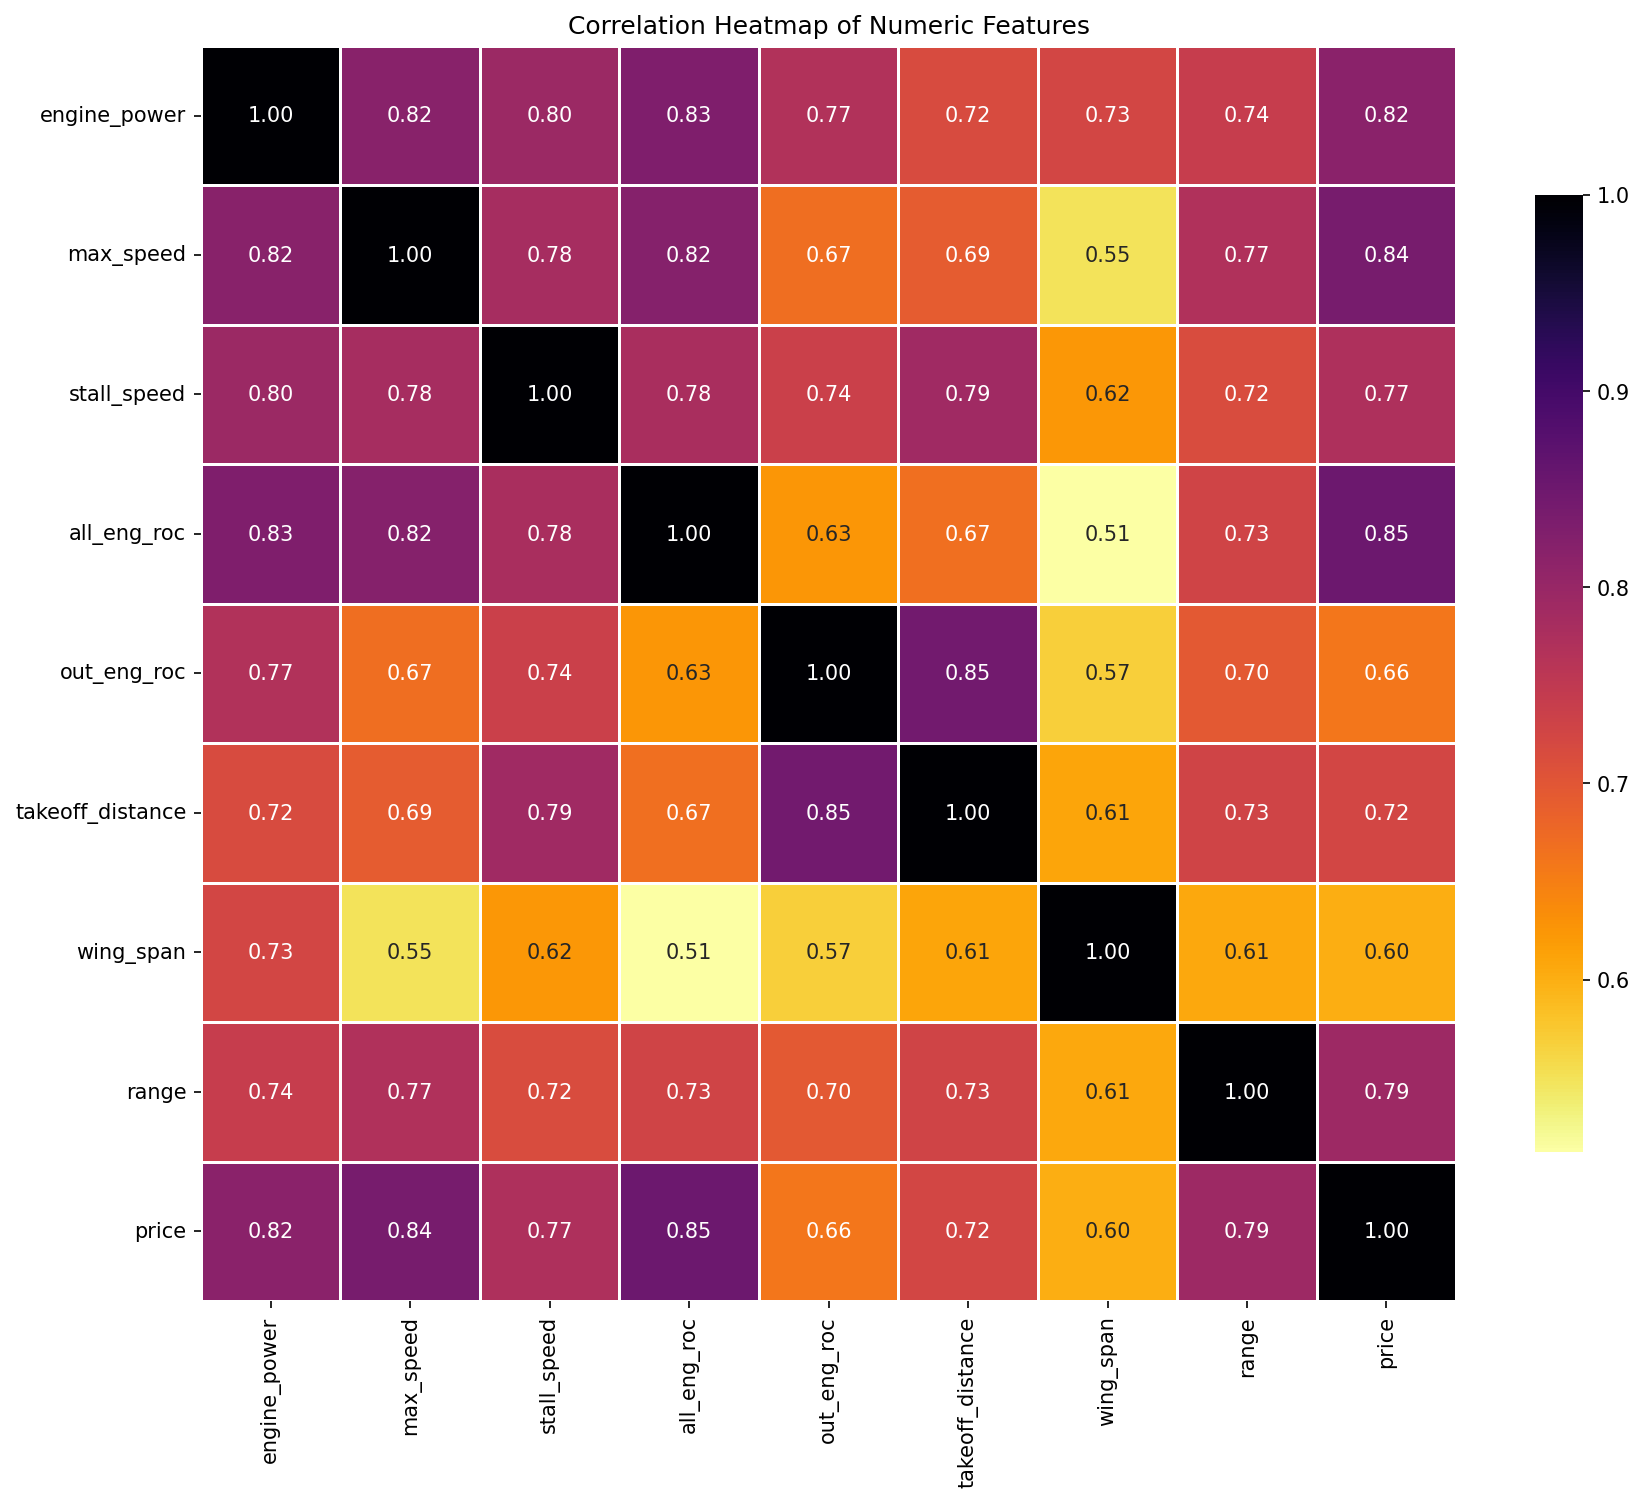

In [743]:
#heatmap    

numeric_data = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 10), dpi=150)
sns.heatmap(
    numeric_data.corr(),
    annot=True,
    fmt='.2f',
    cmap='inferno_r',
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .75}
)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

In [744]:
data.columns

Index(['model_name', 'engine_type', 'engine_power', 'max_speed',
       'cruise_speed', 'stall_speed', 'fuel_tank', 'all_eng_roc',
       'out_eng_roc', 'takeoff_distance', 'landing_distance', 'empty_weight',
       'length', 'wing_span', 'range', 'price'],
      dtype='object')

In [745]:
logData.columns

Index(['model_name', 'engine_type', 'engine_power', 'max_speed',
       'cruise_speed', 'stall_speed', 'fuel_tank', 'all_eng_roc',
       'out_eng_roc', 'takeoff_distance', 'landing_distance', 'empty_weight',
       'length', 'wing_span', 'range', 'price'],
      dtype='object')

In [746]:
df.columns

Index(['model_name', 'engine_type', 'engine_power', 'max_speed', 'stall_speed',
       'all_eng_roc', 'out_eng_roc', 'takeoff_distance', 'wing_span', 'range',
       'price'],
      dtype='object')

In [747]:
#VIF
numeric_data = df.select_dtypes(include=[np.number])
# Handle missing or infinite values in the data
numeric_data_cleaned = numeric_data.replace([np.inf, -np.inf], np.nan).dropna()
numeric_data_with_const = sm.add_constant(numeric_data_cleaned)
# Calcola il VIF per ciascuna variabile
vif_data = pd.DataFrame()
vif_data["Regressor"] = numeric_data_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data_with_const.values, i) for i in range(numeric_data_with_const.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)
print(vif_data)

          Regressor          VIF
0             const  6462.811877
1      engine_power     7.886843
9             price     5.741233
4       all_eng_roc     5.643680
6  takeoff_distance     5.191693
5       out_eng_roc     4.908425
2         max_speed     4.891332
3       stall_speed     4.344890
8             range     3.526301
7         wing_span     2.654361


In [748]:
df['roc_mean'] = (df['all_eng_roc'] + df['out_eng_roc']) / 2
df['speed_margin'] = df['max_speed'] - df['stall_speed']
df['power_per_distance'] = df['engine_power'] / df['takeoff_distance']


In [749]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_new = df[['roc_mean', 'speed_margin', 'power_per_distance', 
            'wing_span', 'range']]   # price esclusa
X_new = add_constant(X_new)


vif = pd.DataFrame()
vif["Regressor"] = X_new.columns
vif["VIF"] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]

print(vif)


            Regressor          VIF
0               const  2327.794622
1            roc_mean     5.889195
2        speed_margin     3.631466
3  power_per_distance     3.148003
4           wing_span     2.129233
5               range     2.909928


In [750]:
#nuovo df
df = df[['price', 'roc_mean', 'speed_margin', 'power_per_distance', 
          'wing_span', 'range']]  # price inclusa
print(df.columns)

Index(['price', 'roc_mean', 'speed_margin', 'power_per_distance', 'wing_span',
       'range'],
      dtype='object')


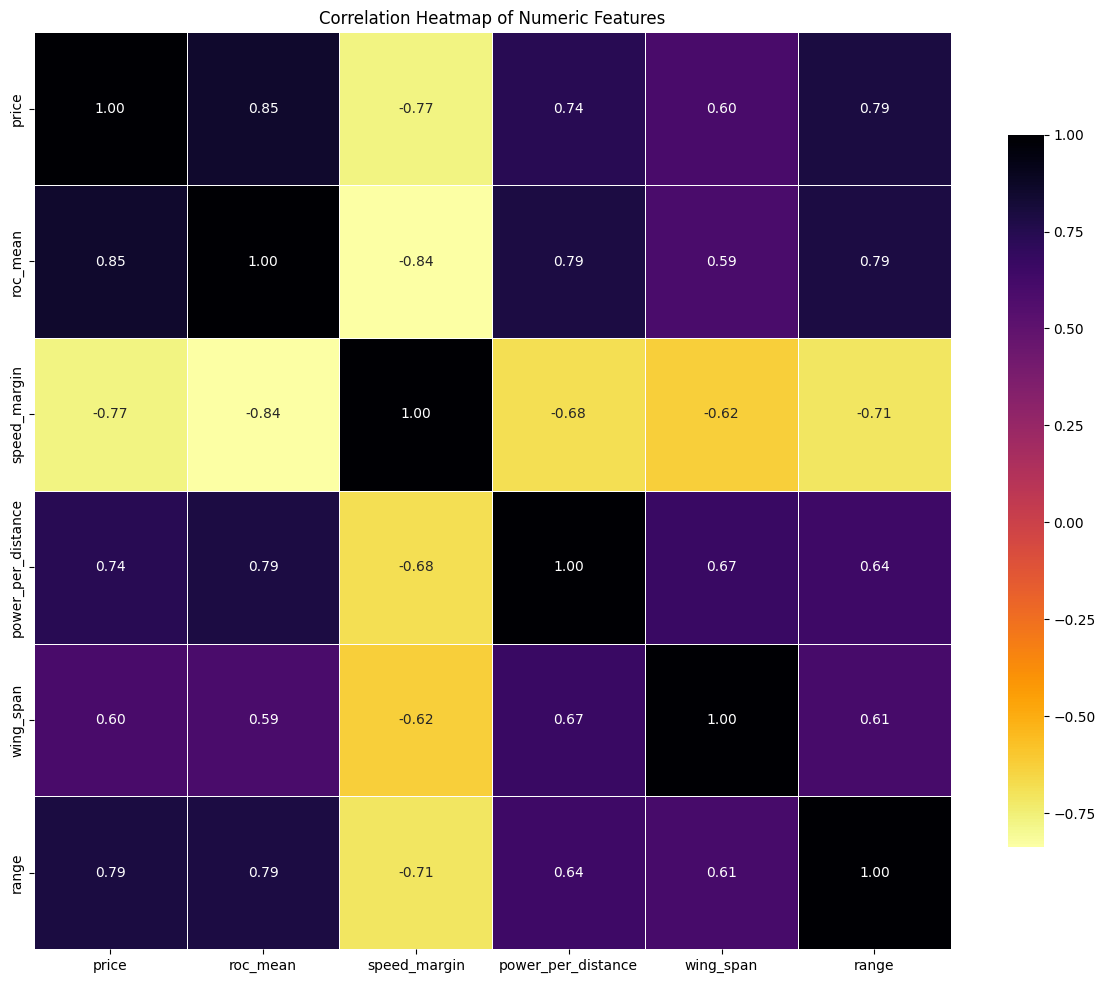

In [751]:
#heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    df.corr(),
    annot=True,
    fmt='.2f',
    cmap='inferno_r',
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .75}
)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

### Heatmap con correlazioni molto alte
# 💡 Passo indietro: stesse feaatures ma non log-trasformate 

### Creazione di nuove features 
- **roc_mean**: velocità di salita media, calcolata come media tra `all_eng_roc` e `out_eng_roc`.  
- **speed_margin**: margine di velocità operativo, ottenuto sottraendo la velocità di stallo (`stall_speed`) dalla velocità massima (`max_speed`).  
- **power_per_distance**: potenza erogata per metro di decollo, dato dal rapporto tra `engine_power` su `takeoff_distance`.  


In [752]:
# Confronto con features non log‐trasformate
df2 = data[['all_eng_roc', 'out_eng_roc', 'max_speed', 'stall_speed',
            'engine_power', 'takeoff_distance', 'wing_span', 'range']].copy()

# nuove feature
df2['roc_mean'] = (df2['all_eng_roc'] + df2['out_eng_roc']) / 2
df2['speed_margin'] = df2['max_speed'] - df2['stall_speed']
df2['power_per_distance'] = df2['engine_power'] / df2['takeoff_distance']
df2['price'] = data['price']



## Rimozione delle features usate per la creazione di nuove features 

In [753]:
# selezione finale
df2 = df2[['price', 'roc_mean', 'speed_margin', 'power_per_distance', 'wing_span', 'range']]

print(df2.columns.tolist())



['price', 'roc_mean', 'speed_margin', 'power_per_distance', 'wing_span', 'range']


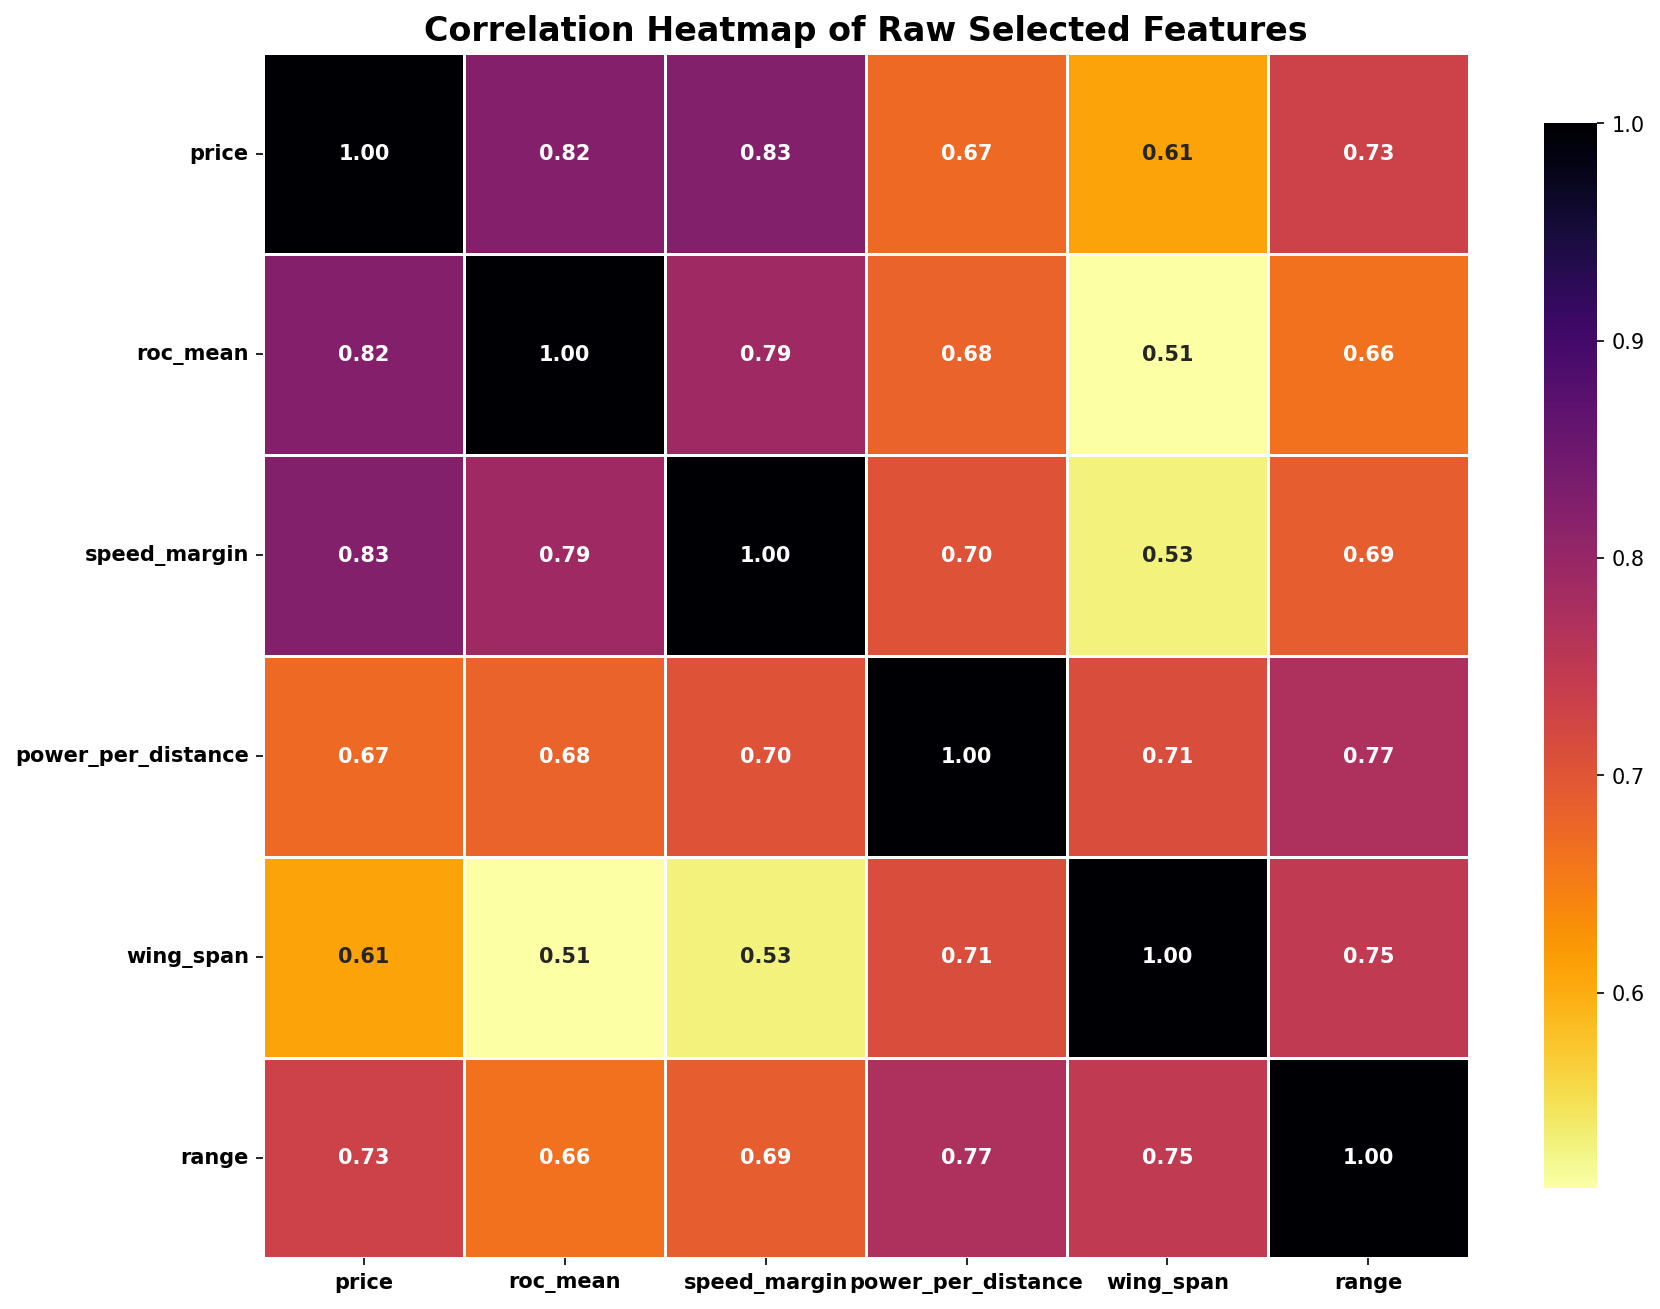

In [754]:
# heatmap
plt.figure(figsize=(12, 10), dpi=150)
sns.heatmap(
    df2.corr(),
    annot=True,
    fmt='.2f',
    cmap='inferno_r',
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .75},
    annot_kws={"size": 10, "weight": "bold"}  # Rendere i numeri più grandi e in grassetto
)
plt.title('Correlation Heatmap of Raw Selected Features', fontsize=16, weight='bold')  # Titolo più grande e in grassetto
plt.yticks(rotation=0, fontsize=10, weight='bold')  # Nomi sull'asse Y orizzontali, più grandi e in grassetto
plt.xticks(fontsize=10, weight='bold')  # Nomi sull'asse X più grandi e in grassetto
plt.tight_layout()
plt.show()

In [755]:
#VIF
numeric_data = df2.select_dtypes(include=[np.number])
# Handle missing or infinite values in the data
numeric_data_cleaned = numeric_data.replace([np.inf, -np.inf], np.nan).dropna()
numeric_data_with_const = sm.add_constant(numeric_data_cleaned)
# Calcola il VIF per ciascuna variabile
vif_data = pd.DataFrame()
vif_data["Regressor"] = numeric_data_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data_with_const.values, i) for i in range(numeric_data_with_const.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)
print(vif_data)
print(df2['price'])

            Regressor        VIF
0               const  42.824371
1               price   4.882032
3        speed_margin   3.952155
2            roc_mean   3.771432
6               range   3.675115
4  power_per_distance   3.415203
5           wing_span   2.681361
0      1300000.0
1      1230000.0
2      1600000.0
3      1300000.0
4      1250000.0
         ...    
512    4100000.0
513    3584000.0
514    3200000.0
515    3240000.0
516    3160000.0
Name: price, Length: 507, dtype: float64


## 💡 Usiamo **log-price**

In [756]:
#ora uso df2 ma con log price
df2['price'] = np.log1p(df2['price'])
# Seleziona le colonne numeriche
numeric_data = df2.select_dtypes(include=[np.number])
# Handle missing or infinite values in the data
numeric_data_cleaned = numeric_data.replace([np.inf, -np.inf], np.nan).dropna()
numeric_data_with_const = sm.add_constant(numeric_data_cleaned)
# Calcola il VIF per ciascuna variabile
vif_data = pd.DataFrame()
vif_data["Regressor"] = numeric_data_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data_with_const.values, i) for i in range(numeric_data_with_const.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)
print(vif_data)


            Regressor          VIF
0               const  3885.365481
3        speed_margin     3.909576
6               range     3.709876
4  power_per_distance     3.636875
1               price     3.510333
2            roc_mean     3.374509
5           wing_span     2.714899


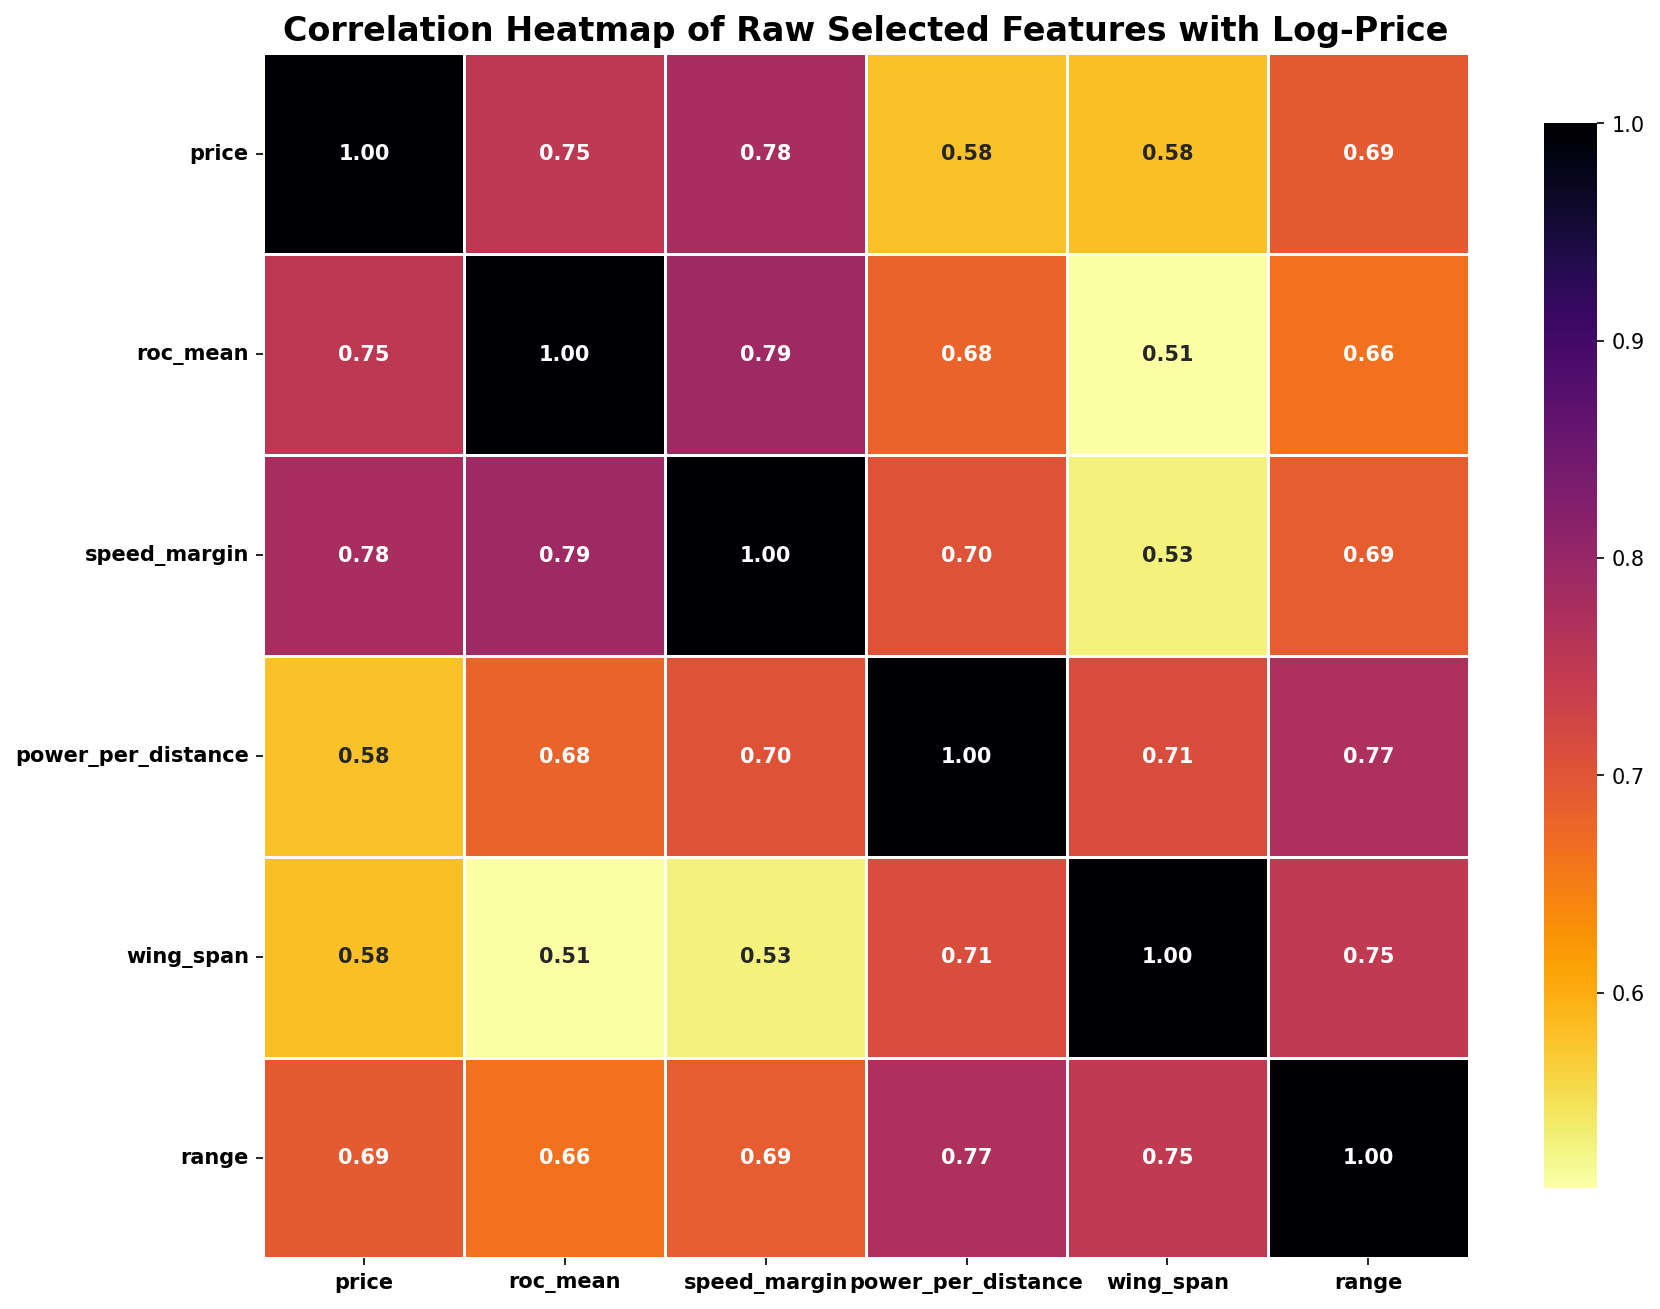

In [757]:

# heatmap
plt.figure(figsize=(12, 10), dpi=150)
sns.heatmap(
    df2.corr(),
    annot=True,
    fmt='.2f',
    cmap='inferno_r',
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .75},
    annot_kws={"size": 10, "weight": "bold"}  # Rendere i numeri più grandi e in grassetto
)
plt.title('Correlation Heatmap of Raw Selected Features with Log-Price', fontsize=16, weight='bold')  # Titolo più grande e in grassetto
plt.yticks(rotation=0, fontsize=10, weight='bold')  # Nomi sull'asse Y orizzontali, più grandi e in grassetto
plt.xticks(fontsize=10, weight='bold')  # Nomi sull'asse X più grandi e in grassetto
plt.tight_layout()
plt.show()


## Conclusione
Dopo la skewness check log trasformando il dataset abbiamo ottenuto distribuzioni più simmetriche e gaussiane. purtroppo dopo la VIF check abbiamo notato che alcune variabili sono altamente collineari.
Nonostante la feature engineering la collinearità è rimasta alta.
### abbiamo deciso dunque di usare solo log price e il resto delle variabili senza log transformation.
Otteniamo dunque VIF piu bassi e una heatmap piu chiara con meno collinearità.

### All data are cleaned from na values 

### data

In [758]:
#save as csv
data.to_csv("Data/aircraft_price_clean.csv", index=False)
data.columns

Index(['model_name', 'engine_type', 'engine_power', 'max_speed',
       'cruise_speed', 'stall_speed', 'fuel_tank', 'all_eng_roc',
       'out_eng_roc', 'takeoff_distance', 'landing_distance', 'empty_weight',
       'length', 'wing_span', 'range', 'price'],
      dtype='object')

### logData

In [759]:
#save as csv
logData.to_csv("Data/aircraft_price_cleaned_log.csv", index=False)
logData.columns

Index(['model_name', 'engine_type', 'engine_power', 'max_speed',
       'cruise_speed', 'stall_speed', 'fuel_tank', 'all_eng_roc',
       'out_eng_roc', 'takeoff_distance', 'landing_distance', 'empty_weight',
       'length', 'wing_span', 'range', 'price'],
      dtype='object')

### After Feature Engineering and with log transformation

In [760]:
#save as csv
df.to_csv("Data/aircraft_price_best-logEngineered.csv", index=False)
df.columns 

Index(['price', 'roc_mean', 'speed_margin', 'power_per_distance', 'wing_span',
       'range'],
      dtype='object')

### After Feature Engineering and with out log transformation except for price

In [761]:
#save as csv
df2.to_csv("Data/aircraft_price_Engineered.csv", index=False)
df2.columns 

Index(['price', 'roc_mean', 'speed_margin', 'power_per_distance', 'wing_span',
       'range'],
      dtype='object')